# Introduction
Natural language processing (NLP) is a branch of computer science concerned with developing computational tools to understand language (text or speech) at the same comptency of a human. NLP is a rapidly growing field that is constantly evolving as new tools and models become the gold standard for language model. Most recently, Bidirectional Encoder Representations from Transformers (BERT), a transformer-based language model devloped at Google (2018), has been regarded as the best model for NLP tasks. In this project, we explore [MatBERT](https://github.com/lbnlp/MatBERT), a pretrained BERT model on materials science literature designed to understand materials science terminologies and paragraph-level scientific reasoning
# Motivation
Within the realm of Materials Sceince Engineering (MSE), as well as many other scientific fields, there exists very few publishers who manage the majority of research publications. Many of these databases are cluttered and unorganized making it difficult to find content relevant to a researcher's interests. Levering state of the art NLP models such as MatBERT, we aim to develop a multi-label classifier capable of classifying MSE abstracts to a specific domain(s) of MSE.
# Authors
This notebook is maintained by Nicholas David (ndavid@andrew.cmu.edu), an undergraduate researcher in the Rollett Group at Carngie Mellon University. Work within this notebook was made possible by researchers at the Lawrence Berkeley National Laboratory cited above for their pre-trained BERT model, MatBERT. Datasets were compiled by Benjamin Glaser and Dr. Amit K. Verma whom which have been tremendous advisors during this project. I would also like to thank Prof. Anthony Rollett for granting me the opprotunity to conduct this research within his group.

# Installs/Notebook Setup

Here, we mount our Google Drive into Google Colab to access stored files such as datasets, MatBERT, etc.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

This code block installs `datasets` and `transformers` [Huggingface](https://huggingface.co/). We also install `tensorflow-addons` to access some additional tensorflow functionality during fine-tuning.



In [ ]:
!pip install datasets
!pip install transformers
!pip install tensorflow-addons
!pip install tensorflow==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 101.7 MB/s eta 0:0

# Preparing the Data

## Importing Scraped Abstracts

Abstracts were scraped from Science Direct and Elsevier by Benjamin Glaser (bmglaser@andrew.cmu.edu). Each subtopic of materials science has it's own import although it's likely that it may contain abstracts relevant to multiple other subtopics as well.

In [ ]:
import pandas as pd
import numpy as np

# Change filepaths as needed
base = "/content/drive/MyDrive/BERT_abstract/"

# Additive Manufacturing
df_am = pd.read_json(base+"training_sets/Additive Manufacturing Elsevier for BERT_new.json")
df_am.rename(columns={'Descriptions' : 'Abstracts'}, inplace=True)

# Refractory Alloys
df_ra1 = pd.read_json(base+"training_sets/Refractory Alloy XML Elsevier with Content 2022_new.json")
df_ra2 = pd.read_excel(base+"training_sets/SpringerNature Refractory Alloy XML.xlsx")
df_ra1.rename(columns={'Descriptions' : 'Abstracts'}, inplace=True)
df_ra2.rename(columns={'Abstract' : 'Abstracts'}, inplace=True)
df_ra_cat = pd.concat([df_ra1, df_ra2], ignore_index=True)
df_ra = pd.DataFrame()
df_ra['Abstracts'] = df_ra_cat['Abstracts']

# Superalloys
df_sa1 = pd.read_excel(base+"training_sets/Superalloy Elsevier with Content.xlsx")
df_sa2 = pd.read_json(base+'training_sets/Superalloys_ScienceDirect_BERT.json')
df_sa_cat = pd.concat([df_sa1, df_sa2], ignore_index=True)
df_sa = pd.DataFrame()
df_sa['Abstracts'] = df_sa_cat['Abstracts']

# HEAs
df_hea1 = pd.read_json(base+'training_sets/HEAs_ScienceDirect_BERT.json')
df_hea2 = pd.read_json(base+'training_sets/HEAs_Elsevier_BERT.json')
df_hea_cat = pd.concat([df_hea1, df_hea2], ignore_index=True)
df_hea = pd.DataFrame()
df_hea['Abstracts'] = df_hea_cat['Abstracts']

# # MSUQ
df_msuq_ = pd.read_excel(base+'training_sets/uq_data.xlsx')
df_msuq = df_msuq_[['Abstracts']].copy()

# Define class list manually IN ORDER
class_list = ['Additive Manufacturing', 'Refractory Alloys', 'Superalloys', 'HEAs', 'UQ']

# Define whether or not to have a none class
NONE_CLASS = True

## Cleaning the Data using Regular Expressions

When scraping text from databases, it is a common practice to then "clean" it to remove any extraneous entities from the data. Since these abstracts are being inputed into a transformer, MatBERT, we attempt to preserve the abstract in it's purest form possible meaning it would read exactly as the author intended it to be read.

In [ ]:
import re
def clean_abstracts(source_list):
    '''
    Cleans imported abstracts while preserving readability

    Args:
        source_list (list): A list of pandas dataframes containing abstracts
    
    Returns:
        cleaned_abs (pandas.DataFrame): A DataFrame containing a cleaned abstracts
    '''
    frames = []
    for df in source_list:
        # Drop missing data
        df = df.dropna()

        # Filter out "Unknown" abstracts
        df = df[df['Abstracts'] != 'Unknown']

        # Filter out abstract fields that only contain KEYWORDS
        df = df.drop(df['Abstracts'].filter(regex='\s*KEYWORDS', axis=0))
        df = df.drop(df['Abstracts'].filter(regex='^KEYWORDS', axis=0))

        # Remove "ABSTRACT" from beginning of abstract fields
        df['Clean_abs1'] = df['Abstracts'].apply(lambda abstract: re.sub(r'^ABSTRACT', '', abstract))

        # Remove any whitespace longer than one space anywhere in abstract
        df['Clean_abs2'] = df['Clean_abs1'].apply(lambda abstract: ' '.join(abstract.split()))

        # Remove special chars. Keep punctuation
        df["Clean_abs3"] = df["Clean_abs2"].apply(lambda abstract : re.sub('[^0-9a-zA-Z:,.?!-]+', ' ', abstract))

        # Remove 'short' noise abstracts
        df['Clean_abs4'] = df['Clean_abs3'].apply(lambda abstract : abstract if len(abstract) > 20 else '')

        # Filter out zero length abstracts
        df = df[df['Clean_abs4'] != '']

        # Reset index
        df = df.reset_index(drop=True)

        # Establish new DataFrame for export
        df_new = pd.DataFrame()
        df_new['Abstract'] = df['Clean_abs4']

        # Case for validation data containing clabels already
        if 'Label' in list(df.columns):
            print('hello')
            df_new['Label'] = df['Label']

        # Append to frame list
        frames.append(df_new)
    
    # Concatenate all cleaned frames
    cat = pd.concat(frames, ignore_index=True)
    if 'Label' in list(cat):
            return cat

    # Drop any duplicates
    cleaned_abs = pd.DataFrame()
    cleaned_abs['Abstract'] = list(set(cat['Abstract'].to_numpy()))
    cleaned_abs = cleaned_abs.reset_index(drop=True)
    assert(len(set(cleaned_abs['Abstract'].to_numpy())) == len(cleaned_abs['Abstract'].to_numpy()))

    return cleaned_abs

In [ ]:
df = clean_abstracts([df_am, df_ra, df_sa, df_hea, df_msuq ])
#df = clean_abstracts([df_am, df_ra, df_sa, df_hea])

## Assigning Labels using Regular Expressions

Since many domains of materials science overlap, we will use a one-hot vector to encode which class(es) an abstract belongs to. For example, if our one-hot vector is of the form `[AM, Superalloys, HEAs]` and an abstract belongs to classes `AM` & `HEAs` then the one-hot vector, *v*, will be `v = [1, 0, 1]`. We make these floats for BCE loss during training.


In [ ]:
def assign_labels(df, regex_list):
    '''
    Assigns one-hot label vector to abstracts using regex

    Args:
        df (pandas.DataFrame): A DataFrame containing cleaned abstracts from all sources
        regex_list (list): A list of regular expressions to label abstracts
    
    Returns:
        df (pandas.DataFrame): A DataFrame with an additional label column using one-hot vectors
    '''

    # Helper function creates one-hot encoding from regex
    def one_hot_from_regex(abstract, regex_list=regex_list):
        label = np.zeros(len(regex_list), dtype=int)
        for i, regex in enumerate(regex_list):
            # Casing in case we use multiple regex
            if type(regex) != list:
                label[i] = 1 if re.search(regex, abstract, re.IGNORECASE) != None else 0
            # Must match at least one regex from each group
            elif type(regex) == list:
                regex_count = 0
                for regex2 in regex:
                    regex_count += 1 if re.search(regex2, abstract, re.IGNORECASE) != None else 0
                label[i] = 1 if regex_count == len(regex) else 0
                regex_count = 0
        return label
    
    # Create column for one-hot encoding labels
    df['Label'] = df['Abstract'].apply(lambda abstract: one_hot_from_regex(abstract))

    return df

Since we'd like to force the model into predicting classes that are mutually exclusive w.r.t material processes and material types, we remove any abstracts labeled as such. Ideally I'd like to restrict the label output space of MatBERT to predict as such, I do not know a way of doing so currently...

In [ ]:
from itertools import product
def exclude_mpxmt(df, mp_index):
    '''
    Excludes abstracts that are materials processes and material types

    Args:
        df (pandas.DataFrame): A DataFrame contained labeled abstracts
        mp_index (int): Index of material process in label

    Returns:
        df (pandas.DataFrame): A DataFrame with such classes excluded
    '''
    # Create permutations of one-hot vector. Place in matrix.
    classes = len(df['Label'].iloc[0])
    perms = product(range(2), repeat=classes)
    # Unwanted perms
    #perms = [perm for perm in perms if perm not in [(0, 1, 1, 1), (1, 1, 1, 1), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 0, 1, 1)]]
    # since we added uq
    perms = [perm for perm in perms if perm [:-1] not in [(0, 1, 1, 1), (1, 1, 1, 1), (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1), (1, 1, 1, 0), (1, 1, 0, 1), (1, 0, 1, 1)]]

    perm_mat = np.zeros(((2**classes)-2, classes))
    for i, perm in enumerate(perms):
        perm_mat[i, :] = np.array(list(perm))
    
    frames = []
    for perm in perm_mat:
        frame = df[df['Label'].apply(lambda label: np.all(np.equal(label, perm)))]
        frame = frame.reset_index(drop=True)
        frames.append(frame)

    # Concatenate into one DataFrame and reset_index
    df_final = pd.concat(frames).reset_index(drop=True)

    return df_final

Define our regex's and assign labels to abstracts

In [ ]:
# # DEFINE REGEX HERE

# DEFINE REGEX HERE
superalloy_regex = '|'.join([r'superalloy', r'super alloy', r'super-alloy', r'high performance alloy', r'high-performance alloy', 
                             r'inconel', r'alloy 718', r'ni-based', r'ni based', r'co-based', r'co based', r'nickel based', 
                             r'nickel-based', r'cobalt based', r'cobalt-based', r'Alloy 740H', r'Haynes 282', r'Waspaloy', r'RR1000', r'GH720Li'])
heas_regex = '|'.join([r'high entropy alloy', r'high-entropy alloy', r'high-entropy-alloy', r'high-performance-alloy', r'high performance alloy', r'high-performance alloy', r' hea ', r' heas ', r'\(heas\)', r'\(hea\)'])
am_regex = '|'.join([r'Additive Manufacturing'])

refractory_regex_elems = '|'.join([r'zirconium', r'niobium', r'molybdenum', r'hafnium', r'tantalum', r'tungsten', r'rhenium', r'refractory'])
refractory_regex_props = '|'.join([r'mechanical behavior', r'mechanical properties', r'strength', r'ductility', r'ductile to brittle transition temperature', r' dbtt ', r'cracking'])

msuq_regex = '|'.join([r'bayesian', r'aleatoric ', r'aleatory', r'epistemic', r'gaussian', r'gaussian processes',
                       r'inference', r'monte carlo simulation', r'mc dropout', r'maximum likelihood estimation', r'maximum a posteriori estimation', 
                       r'maximum likelihood', r'kullback–leibler divergence', r'model averaging', r'probability density', 
                       r'cumulative distribution', r'predictive density', r'prior probability', r'posterior probability',
                       r'random', r'random field', r'random variable', r'polynomial chaos expansion', r'stochastic', 
                       r'stochastic collocation', r'stochastic finite elements', r'spectral stochastic', r'stochastic process',
                       r'surrogate model', r'metamodel', r'reliability', r'sensitivity', r'normal distribution',
                       r'mean', r'standard deviation', r'variance'])

msuq_regex = '|'.join([r'bayesian', r'aleatoric ', r'aleatory', r'epistemic',
                       #r'gaussian', 
                       r'gaussian processes',
                       r'inference', r'monte carlo simulation', r'mc dropout', r'maximum likelihood estimation', r'maximum a posteriori estimation', 
                       r'maximum likelihood', r'kullback–leibler divergence', r'model averaging', r'probability density', 
                       r'cumulative distribution', r'predictive density', r'prior probability', r'posterior probability',
                       #r'random', 
                       r'random field', r'random variable', r'polynomial chaos expansion', r'stochastic', 
                       r'stochastic collocation', r'stochastic finite elements', r'spectral stochastic', r'stochastic process',
                       r'surrogate model', r'metamodel', r'reliability', r'sensitivity', r'normal distribution',
                       #r'mean', r'standard deviation', r'variance'
                       ])


# Put regex into list
regex_list = [am_regex, [refractory_regex_elems, refractory_regex_props], superalloy_regex, heas_regex, msuq_regex]

# Assign labels
df = assign_labels(df, regex_list)
print(len(df))

# Remove mat process + mat type
df = exclude_mpxmt(df, 0)
print(len(df))

199969
2528940


In [ ]:
np.unique(np.array(df['Label'].tolist()), axis=0)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 1, 0, 0],
       [1, 0, 1, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 1]])

## Training & Test Split

In machine learning, it is important to create two sets of data: one for training and one for testing. Here the training set is used to fine-tune the model to acquant it with our data. The test set is used to evaluate the models performance since the test data is left unseen to the model. It is important to not share abstracts between the two sets. It is also import to have each class equally represented to prevent label inbalance, causing the classifier to only learn one class.

In [ ]:
from datasets import Dataset
from itertools import product
import matplotlib.pyplot as plt

def create_train_test(df, split=[.8, .2], limit=1000, create_hist=False, class_list=class_list):
    '''
    Creates training and test splits of the data ensuring label balance.
    Optionally create histogram displaying label frequency

    Args:
        df (pandas.DataFrame): A Pandas DataFrame containing labeled abstracts
        split (list): Optional argument specifying split size [train, test]
        limit (int): Optional argument specifying the limit for the size of any class
        create_hist (bool): Optional argument specifying whether to make histogram
        class_list (list): Dummy argument for string class labels
    
    Returns:
        dataset (dataset.Dataset): A huggingface Dataset containing training
            and test data
        df_final (pandas.DataFrame): A pandas DataFrame containing the final data for training and split
    '''
    
    # Ensure split sums to 1
    assert(sum(split) == 1)

    # Shuffle df
    df = df.sample(frac=1).reset_index(drop=True)

    # Create permutations of one-hot vector. Place in matrix.
    classes = len(df['Label'].iloc[0])
    perms = product(range(2), repeat=classes)
    perm_mat = np.zeros((2**classes, classes))
    for i, perm in enumerate(perms):
        perm_mat[i, :] = np.array(list(perm))
    
    frames = []
    # Now we take abstracts according to split without exceeding limit
    for perm in perm_mat:
        frame = df[df['Label'].apply(lambda label: np.all(np.equal(label, perm)))]
        frame_size = len(frame)

        # Less then limit we limit by abstract size
        if len(frame) <= limit:
            frames.append(frame)
        else:
            frame = frame.reset_index(drop=True)
            frames.append(frame.loc[0:limit])

    # Concatenate into one DataFrame and reset_index
    df_final = pd.concat(frames).reset_index(drop=True)

    # Convert to huggingface dataset
    dataset = Dataset.from_pandas(df_final)

    # Rename to follow schema
    dataset = dataset.rename_column('Abstract', 'text')
    dataset = dataset.rename_column('Label', 'label')

    # Perfrom split
    dataset = dataset.train_test_split(test_size=split[1])

    # Optionally create historgram displaying label frequency
    if create_hist:
        def one_hot_to_string_label(one_hot, class_list):
            indices = []
            for i, label in enumerate(one_hot):
                if label == 1:
                    indices.append(i)
            if len(indices) == 0:
                return 'None'
            s = ''
            for i, index in enumerate(indices):
                s += class_list[index]
                if i != len(indices)-1:
                    s += ' & '
            return s
        
        # Create frequency dictionary using label string as keys
        freq = dict()
        for perm in perm_mat:
            s = one_hot_to_string_label(perm, class_list)
            freq[s] = len(df_final[df_final['Label'].apply(lambda label: np.all(np.equal(label, perm)))])

        # Figure Size
        fig, ax = plt.subplots(figsize =(16, 9))
 
        # Horizontal Bar Plot
        ax.barh(list(freq.keys()), freq.values())

        ax.set_title('Label Distribution',
             loc ='left', )
        plt.show()

    return dataset

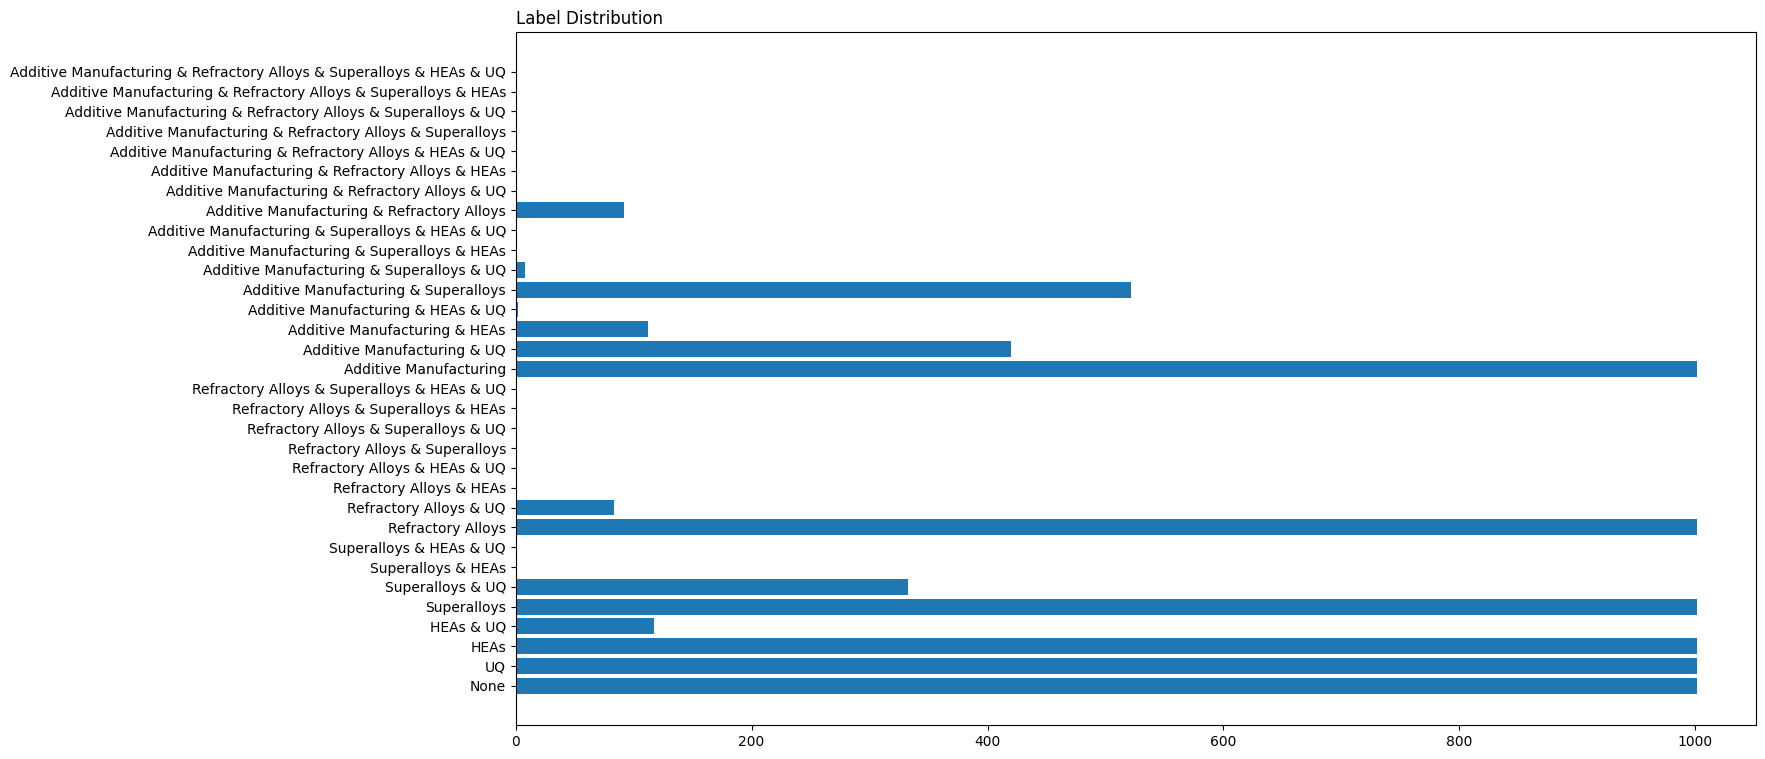

In [ ]:
dataset = create_train_test(df, create_hist=True)

## Tokenization 

Tokenizing text allows models to more easily manipulate words since they are now numbers. Here we load the MatBERT tokenizer to created (512, 768) vectors for each abstract. We will also create training and test splits of our data being sure to maintain label balance.

In [ ]:
from transformers import BertTokenizerFast
from datasets import Dataset

def tokenize_abstracts(dataset):
    '''
    Uses MatBERT to tokenize abstracts for fine-tuning

    Args: dataset (DatasetDict): A huggingface dataset 
        dictionary containing train and test data

    Returns: tokenized_dataset (DatasetDict): A hugginface
        dataset dictionary containing tokenized training and test data
    '''

    # Load the tokenizer
    tokenizer = BertTokenizerFast.from_pretrained(base+"MatBERT/matbert-base-cased", do_lower_case=False)

    # Define a max abstract length
    MAX_LENGTH = 512

    def tokenize_function(examples):
        '''Applies tokenizer to abstract text'''
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)

    return tokenized_dataset

In [ ]:
tokenized_dataset = tokenize_abstracts(dataset)

Map:   0%|          | 0/6156 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

# Fine-tuning

## Load the Model

We load the model as `TFBertForSequenceClassification` specifying the `problem_type = "multi_label_classification"` and the number of labels `num_labels` = number of single classes.

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from transformers import TFBertForSequenceClassification

# Load the model from Google Drive path. from_pt=True (the model is loaded from a pytorch_model.bin)
model = TFBertForSequenceClassification.from_pretrained(base+"MatBERT/matbert-base-cased", 
                                                        problem_type="multi_label_classification", num_labels=len(df['Label'].iloc[0]), from_pt=True)

# Load the tokenizer again
tokenizer = BertTokenizerFast.from_pretrained(base+"MatBERT/matbert-base-cased", do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorc

## Converting Dataset to Tensorflow Tensors

Since we are loading the pretrained model as TF, we must convert our datasets to Tensorflow Tensors. Below we define the `BATCH_SIZE` which limits the number of abstracts being sent to the model at any given time. This is done to aleviate memory. The training set is also shuffled so each epoch sees batches in a different order.



In [ ]:
def dataset_to_tf(tokenized_dataset, batch_size=8):
    '''
    Converts huggingface dataset to Tensorflow tensors for fine-tuning

    Args:
        tokenized_dataset (DatasetDict): A huggingface dataset dictionary containing
            tokenized train and test data
        batch_size (int): Optionally batch size

    Returns:
        train_tf_dataset (BatchDataset): Batched tensorflow tensors containing
            train data
        test_tf_dataset (BatchDataset): Batched tensorflow tensors containing
            test data
    '''

    BATCH_SIZE = batch_size

    # Transfer to tf
    tf_train_dataset = tokenized_dataset['train'].remove_columns(["text"]).with_format("tensorflow")
    tf_test_dataset = tokenized_dataset['test'].remove_columns(["text"]).with_format("tensorflow")

    # Convert everything in big tensors
    train_features = {x: tf_train_dataset[x] for x in tokenizer.model_input_names}
    train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, tf_train_dataset["label"]))
    train_tf_dataset = train_tf_dataset.shuffle(len(tf_train_dataset)).batch(BATCH_SIZE)

    test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
    test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["label"]))

    # Batch
    test_tf_dataset = test_tf_dataset.batch(BATCH_SIZE)
    
    return train_tf_dataset, test_tf_dataset

In [ ]:
train_tf_dataset, test_tf_dataset = dataset_to_tf(tokenized_dataset)

In [ ]:
len(test_tf_dataset)


193

## Training

Now we are ready to fine-tune our model to our data. Here we can experiment with certain hyperparameters such as the learning rate, optimizer, number of epochs, etc.

In [ ]:
def fine_tune(model, tf_train, tf_test, freeze=False, EPOCHS=3, LR=5e-5, adamW=False):
    '''
    Fine-tunes MatBERT outputting the model corresponding to the highest test accuracy.
    Saves weights to "best_weights.hdf5".
    Saves training log to "cvs_log.csv".
    Saves model to "fine-tuned_multi-label_MatBERT"

    Args:
        model (TFBertforsequenceclassification): MatBERT
        tf_train (BatchDataset): Batched TF dataset containing tokenized training data
        tf_test (BatchDataset): Batched TF dataset containg tokenized test data
        freeze (bool): Optional bool indicating whether to freeze the base model
        EPOCHS (int): Optional number of epochs to fine-tune for
        LR (float): Optional value for learning rate
        adamW (bool): Optional bool to use adamW optimizer instead of Adam
    
    Returns:
        model (TFBertforsequenceclassification): fine-tuned MatBERT
    '''

    # Optionally freeze the base model
    model.layers[0].trainable = not freeze
    print("1")

    # Callback records statistics for each epoch
    cvs_log = tf.keras.callbacks.CSVLogger('cvs_log.csv', separator=",", append=False)
    print("2")

    # Callback uses checkpoints to save model weights with best val_accuracy
    weights_filepath = 'best_weights.hdf5'
    best_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weights_filepath, 
                                monitor='val_binary_accuracy',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='max')
    print("3")

    # Fine-tuning hyperparameters
    EPOCHS = EPOCHS
    LR = LR
    STEPS_PER_EPOCH = len(tf_train)
    print("4")

    # Implementing learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                                  LR,
                                                                  decay_steps = STEPS_PER_EPOCH*1000,
                                                                  decay_rate=1,
                                                                  staircase=False)
    print("5")

    # AdamW Optimzer
    optimizer_W = tfa.optimizers.AdamW(learning_rate=LR, weight_decay=1e-2)
    print("6")

    # Define optimizer
    optimizer = optimizer_W if adamW else tf.keras.optimizers.Adam(learning_rate=LR)
    print("7")

    # Callback saves best accuracy model regardless
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.BinaryAccuracy()],
    )
    print("8")

    # History tracks metrics during fine-tuning
    history = model.fit(tf_train, validation_data=tf_test, epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH, callbacks=[best_model_checkpoint, cvs_log])
    print("9")

    # Load the best weights for the model
    model.load_weights(weights_filepath)
    print("10")

    # Optionally save the model
    model.save_pretrained("fine-tuned_multi-label_MatBERT")
    print("11")

    return model

In [ ]:
model.save_pretrained(base+"fine-tuned_multi-label_MatBERT")

In [ ]:
model = fine_tune(model, train_tf_dataset, test_tf_dataset, EPOCHS=3, freeze=False)

1
2
3
4
5
6
7
8
Epoch 1/3
770/770 [==============================] - 801s 1s/step - loss: 0.1077 - binary_accuracy: 0.9646 - val_loss: 0.0448 - val_binary_accuracy: 0.9897
Epoch 2/3
770/770 [==============================] - 776s 1s/step - loss: 0.0410 - binary_accuracy: 0.9898 - val_loss: 0.0414 - val_binary_accuracy: 0.9906
Epoch 3/3
770/770 [==============================] - 774s 1s/step - loss: 0.0247 - binary_accuracy: 0.9939 - val_loss: 0.0474 - val_binary_accuracy: 0.9895
9
10
11


In [ ]:
# checkpoint_path = "train_model.ckpt"
# model.save_weights(checkpoint_path.format(epoch=0))

# Analysis

## Clustering

Clustering is a common unsupervised learning method used to visualize data. Typically vector representations of data in some high dimensional space are reduced to principal components (PC1, PC2) allowing us to visualize high dimensional data in 2D. Here we use clustering to visualize our model's performance and to evaluate the embeddings it learns. Below we employ t-distributed stochastic neighbor embedding (t-SNE) to perform dimension reduction on the `[CLS]` token of our models last encoder. This token is commonly used for classification whereas the entire embedding is considered a 'verbose' representation of our data.

In [ ]:
def gen_embeddings(tokenized_dataset, model, mode='CLS'):
    '''
    Generates embeddings of the tokenized_dataset.

    CLS = Uses the CLS token (first hidden state vector) for embeddings
    POOL = Averages the hidden states of each token excluding PAD tokens

    Args:
        tokenized_dataset (BatchDataset): Batched TF dataset containing tokenized data
        model (TFBertforsequenceclassification): Fine-tuned MatBERT
        mode (string): Optionally embedding config. Use 'CLS' or 'POOL'

    Returns:
        embeddings (np.array): Embeddings either from CLS_hidden or POOL_hidden
        labels (np.array): Labels
    '''

    # Find num_data
    num_data = len(list(tokenized_dataset.unbatch().as_numpy_iterator()))

    # Allocate arrays for quicker runtimes
    CLS_hidden = np.zeros((num_data, 768))
    POOL_hidden = np.zeros((num_data, 768))
    labels = np.zeros((num_data, len(list(tokenized_dataset.unbatch().as_numpy_iterator())[0][1])))

    # Used to mark where [PAD] tokens start
    attention_stop_index = np.zeros(num_data)
    prev_batch_iter = 0

    for i, batch in enumerate(tokenized_dataset):
        # Keep track of indexing
        batch_iter = prev_batch_iter + batch[1].shape[0]
        outputs = model(batch, output_attentions=True, output_hidden_states=True)
        if mode == 'CLS':
            # Grab the [CLS] token of the last layer for all batches across dim 768
            CLS_hidden[prev_batch_iter:batch_iter, :] = outputs.hidden_states[-1][:, 0, :].numpy()
        elif mode == 'POOL':
            att = outputs.attentions[-1][:, 0, 0, :].numpy()
            for j, b in zip(range(prev_batch_iter, batch_iter), range(batch_iter-prev_batch_iter)):
                # In case abstract occupies entired 512 MAX_LENGTH encoding
                # Find where attentions are 0 (these indicate start of [PAD] tokens)
                try: stop_index = np.where(att[b, :] == 0)[0][0]
                except: stop_index = 512
                attention_stop_index[j] = stop_index
                # Grab only the non [PAD] tokens and average them
                POOL_hidden[j] = outputs.hidden_states[-1][:, 0:stop_index, :].numpy().sum()/stop_index
        labels[prev_batch_iter:batch_iter] = batch[-1].numpy()
        prev_batch_iter = batch_iter

    # Check for normalization then output accordingly
    if mode == 'CLS':
        if not (np.all(CLS_hidden <= 1) and np.all(CLS_hidden >= -1)):
            CLS_hidden /= np.linalg.norm(CLS_hidden)
        return CLS_hidden, labels
    elif mode == 'POOL':
        if not (np.all(POOL_hidden <= 1) and np.all(POOL_hidden >= -1)):
            POOL_hidden /= np.linalg.norm(POOL_hidden)
        return POOL_hidden, labels

    return None

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

def gen_clustering_plot(fname, plt_title, embeddings, labels, perplexity=30):
    '''
    Generates and saves clustering TSNE plots of embeddings

    Args:
        fname (string): Filename for .png plot output
        plt_title (string): Plot title
        embeddings (np.array): Embedded data
        labels (np.array): Data's corresponding labels
        perplexity (int): Optionally t-SNE perplexity toggle

    Returns:
        x_embedded (np.array): Dimension reduced embeddings
    '''

    def one_hot_to_color(labels, ret_map=False):
        '''
        Converts one-hot encoding to colors (only works with length 3)

        Args:
            labels (np.array): One-hot labels
            ret_map (bool): Optionally return color mapping only

        Returns:
            c_arr (list): Labels now as colors
            OR
            ret_map (dict): Color mapping
        '''
        uniq = np.unique(labels, axis=0)
        d = dict()
        #c_list = ['yellow', 'red', 'blue', 'black', 'green', 'purple', 'orange', 'brown', 'pink']
        # c_list = ["#FF0000", "#FFA500", "#FFFF00", "#008000", 
        #           "#0000FF", "#4B0082", "#EE82EE", "#808080", 
        #           "#FFFFFF", "#000000", "#FFC0CB", "#00FFFF", 
        #           "#ADD8E6", "#FFFFE0", "#7FFFD4", "#FF6347"]
        c_list = ["#800000", "#9A6324", "#808000", "#469990", 
                  "#000080", "#e6194b", "#3cb44b", "#ffe119", 
                  "#4363d8", "#f58231", "#911eb4", "#42d4f4", 
                  "#f032e6", "#bfef45", "#fabebe", "#469990"]


        for x in uniq:
            d[tuple(x)] = c_list.pop()
        if ret_map:
            return d
        f = lambda x: d[tuple(x)]
        c_arr = []
        for v in labels:
            c_arr.append(d[tuple(v)])
        return c_arr

    # Generate legend elemetns manually    
    legend_elements = []
    d = one_hot_to_color(labels, ret_map=True)
    for k, v in d.items():
        k = [int(x) for x in k]
        element = Line2D([0], [0], marker='o', color='w', label=k, markerfacecolor=v, markersize=8)
        legend_elements.append(element)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=5000, metric='euclidean', init='random', 
            method='barnes_hut')
    x_embedded = tsne.fit_transform(embeddings)
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    scatter = ax.scatter(x_embedded[:, 0], x_embedded[:, 1], c=one_hot_to_color(labels), s=40, cmap='viridis')
    legend = ax.legend(handles=legend_elements, title="Classes", prop={'size': 20}, framealpha=0.5)
    legend.get_title().set_fontsize(20)
    ax.add_artist(legend)
    #ax.set_title(plt_title)
    ax.set_xlabel('tSNE_1', fontsize=20)
    ax.set_ylabel('tSNE_2', fontsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    plt.savefig(fname)
    plt.show()
    return x_embedded

Generate the embeddings

In [ ]:
embeddings_train, labels_train = gen_embeddings(train_tf_dataset, model, mode='CLS')
embeddings_test, labels_test = gen_embeddings(test_tf_dataset, model, mode='CLS')

Produce the clustering plots

<ipython-input-24-2d4e85ae6d53>:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_embedded[:, 0], x_embedded[:, 1], c=one_hot_to_color(labels), s=40, cmap='viridis')


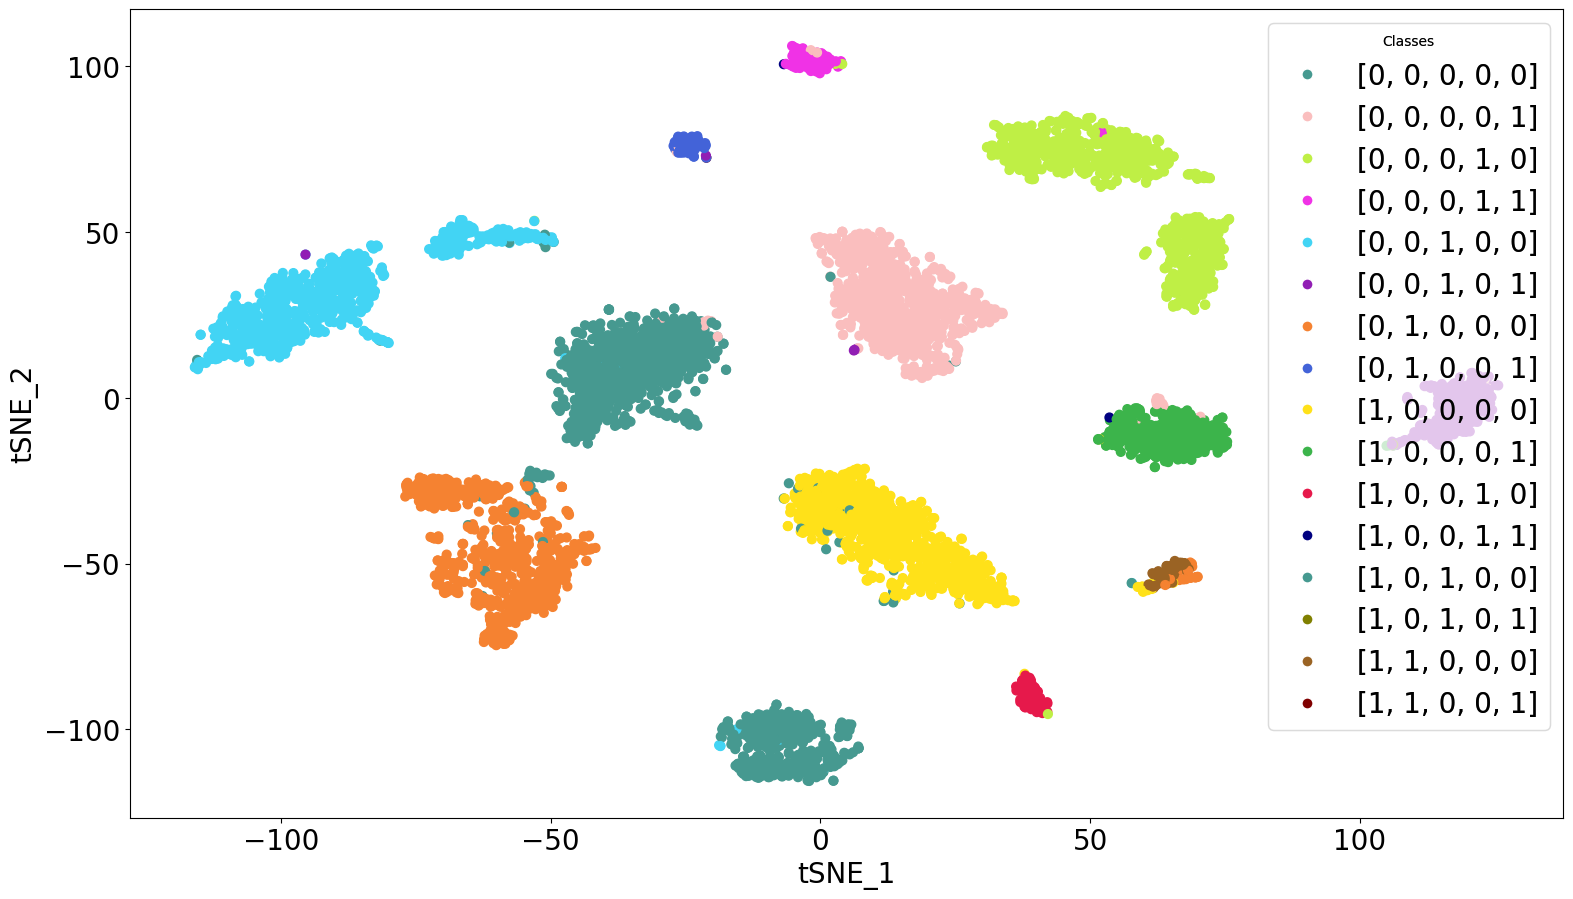

In [ ]:
tsne_embeddings_train = gen_clustering_plot('train_tsne_CLS.png', f'TSNE CLS Hidden States of Training Data (N = {len(labels_train)})', embeddings_train, labels_train, perplexity=30)
#tsne_embeddings_test = gen_clustering_plot('test_tsne_CLS.png', f'TSNE CLS Hidden States of Test Data (N = {len(labels_test)})', embeddings_test, labels_test, perplexity=30)

<ipython-input-24-2d4e85ae6d53>:69: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(x_embedded[:, 0], x_embedded[:, 1], c=one_hot_to_color(labels), s=40, cmap='viridis')


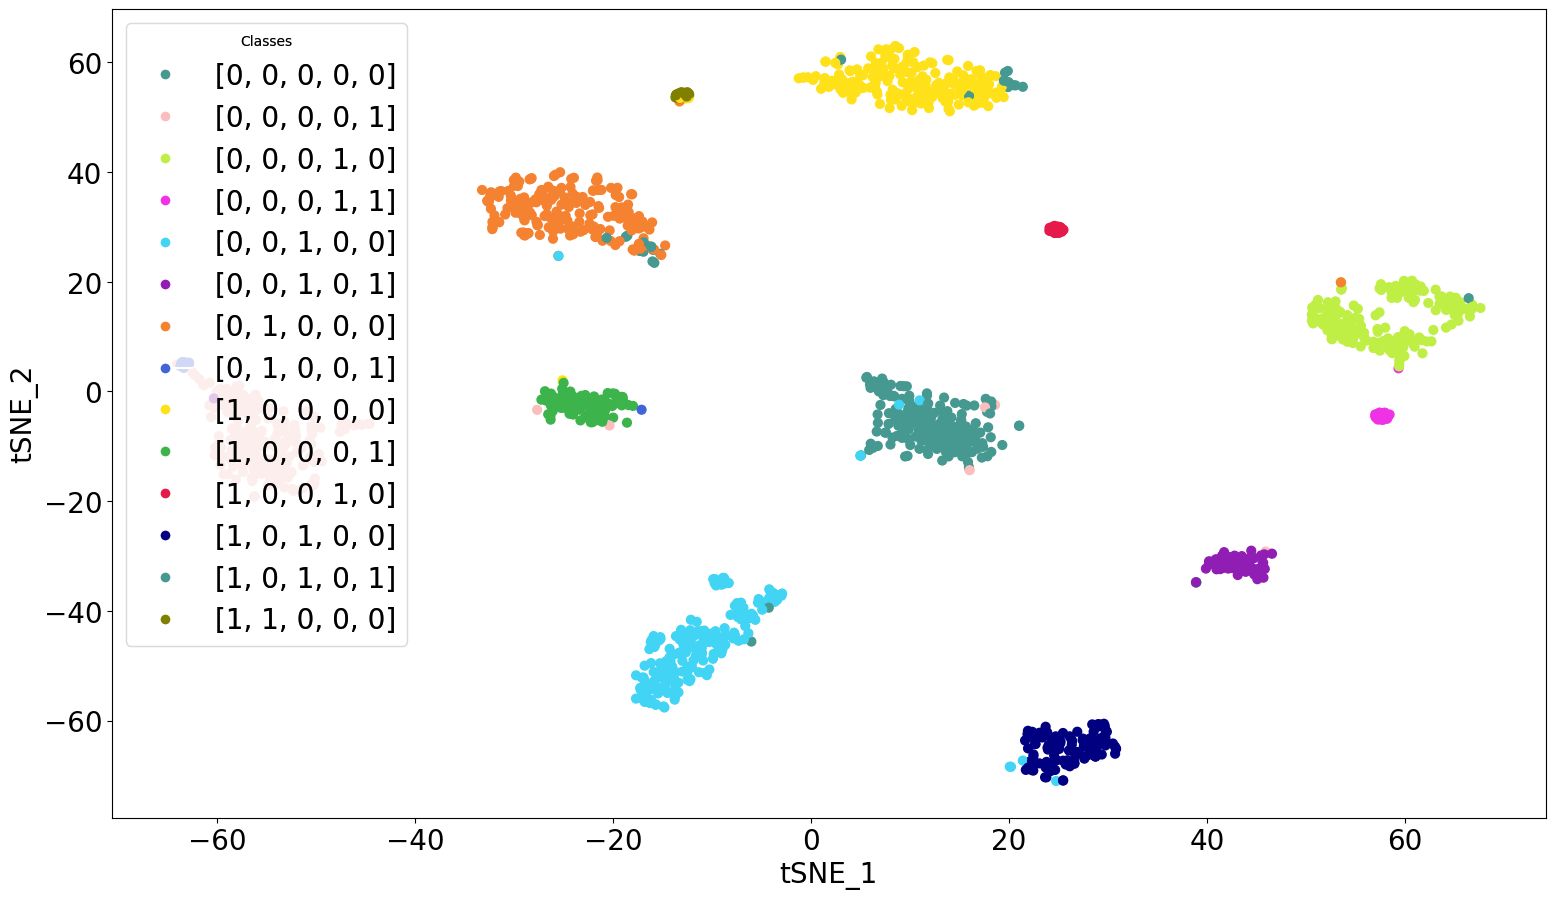

In [ ]:
tsne_embeddings_test = gen_clustering_plot('test_tsne_CLS.png', f'TSNE CLS Hidden States of Test Data (N = {len(labels_test)})', embeddings_test, labels_test, perplexity=30)

## Score Reports

Below we have different score report functions for train and test due to some isses that arise during batching.

In [ ]:
import sklearn.metrics
from math import isclose

def score_report_train(dataset, model):
    '''
    Prints the score report of test data and returns train labels and predictions

    Args: 
        dataset (BatchDataset): Batched TF dataset containing tokenized train data
        model (TFBertforsequenceclassification): MatBERT model

    Returns:
        y_train (np.array): Train labels
        y_pred (np.array): Predicted labels
    '''
    num_abs = len(list(dataset.unbatch().as_numpy_iterator()))
    num_class = len(list(dataset.unbatch().as_numpy_iterator())[0][1])
    y_train = np.zeros((num_abs, num_class), dtype=int)
    y_probs = np.zeros((num_abs, num_class), dtype=float)
    for i, batch in enumerate(dataset):
        batch_size = len(batch[1])

        # # The evaluation set's labels
        # y_train = np.hstack((y_train, batch[1].numpy()))

        # # Model's probabilities from logits
        # y_probs = np.vstack((y_probs, model.predict(batch).logits))

        # The evaluation set's labels
        y_train[i*batch_size:(i+1)*batch_size, :] = batch[1].numpy()

        # Model's probabilities from logits
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_probs[i*batch_size:(i+1)*batch_size, :] = np.apply_along_axis(sigmoid, 1, model.predict(batch).logits)
    
    print(y_probs)
    print('---')
    # Convert to labels
    pred = lambda x: 1 if x > 0.5 else 0
    vpred = np.vectorize(pred)
    y_pred = vpred(y_probs)

    print(y_pred)
    print('---')
    print(y_train)

    # Accuracy score
    acc = sklearn.metrics.accuracy_score(y_train, y_pred)

    # More metrics
    precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(y_train, y_pred, average='weighted')

    # Fancy-print
    #print(conf_mat)
    print("-----------------")
    print("Accuracy: ", acc)
    print("-----------------")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)
    # Support will be None since average='weighted'
    print("Support: ", support)

    # Sanity check to ensure we're outputting the correct metrics
    #assert(isclose(model.evaluate(dataset, verbose=0)[1], acc, rel_tol=1e-5))
    return y_train, y_pred

In [ ]:
import sklearn.metrics
from math import isclose

def score_report_test(dataset, model):
    '''
    Prints the score report of test data and returns test labels and predictions

    Args: 
        dataset (BatchDataset): Batched TF dataset containing tokenized test data
        model (TFBertforsequenceclassification): MatBERT model

    Returns:
        y_test (np.array): Test labels
        y_pred (np.array): Predicted labels
    '''

    # The evaluation set's labels
    y_test = np.concatenate([y for x, y in dataset], axis=0)

    # Model's probabilities from logits
    y_probs = model.predict(dataset).logits

    # # Apply sigmoid
    # sigmoid = lambda x: 1 / (1 + np.exp(-x))
    # vsig = np.vectorize(sigmoid)
    # y_probs = vsig(y_probs)

    # print(y_probs)

    print('y_test', y_test)

    # Predict
    pred = lambda x: float(1) if x >= float(0) else float(0)
    vpred = np.vectorize(pred)
    y_pred = vpred(y_probs)

    print('y_pred', y_pred)

    # # Convert to labels
    # y_pred = y_probs[0].argmax(axis=-1)

    # # Confusion matrix 
    # conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)
    # conf_mat = pd.DataFrame(conf_mat)

    # Accuracy score
    acc = sklearn.metrics.accuracy_score(y_test, y_pred)

    # More metrics
    precision, recall, f1, support = sklearn.metrics.precision_recall_fscore_support(y_test, y_pred, average='weighted')

    # Fancy-print
    print("-----------------")
    print("Accuracy: ", acc)
    print("-----------------")
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1: ", f1)
    # Support will be None since average='weighted'
    print("Support: ", support)

    # Sanity check to ensure we're outputting the correct metrics
    #assert(isclose(model.evaluate(dataset, verbose=0)[1], acc, rel_tol=1e-5))
    return y_test, y_pred

In [ ]:
y_train, y_pred_train = score_report_train(train_tf_dataset, model)
y_test, y_pred_test = score_report_test(test_tf_dataset, model)

1/1 [==============================] - 0s 184ms/step
[[1.84684840e-03 2.47499556e-03 1.06320949e-03 9.93696630e-01
  4.51579923e-03]
 [2.46728119e-03 1.85447023e-03 9.97536421e-01 7.90228485e-04
  5.22512291e-03]
 [1.86215353e-03 1.72038097e-03 9.97342765e-01 7.17998308e-04
  8.44189804e-03]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
---
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
---
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 ...
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
-----------------
Accuracy:  0.9866796621182586
-----------------
Precision:  0.9921719962688242
Recall:  0.9951024042742653
F1:  0.9936304270645758
Support:  None
193/193 [==============================] - 67s 333ms/step
y_test [[0 0 0 1 0]
 [0 0 1 0 1]
 [0 0 0 0 1]
 ...
 [0 0 0 1 0]

## Confusion Matrix

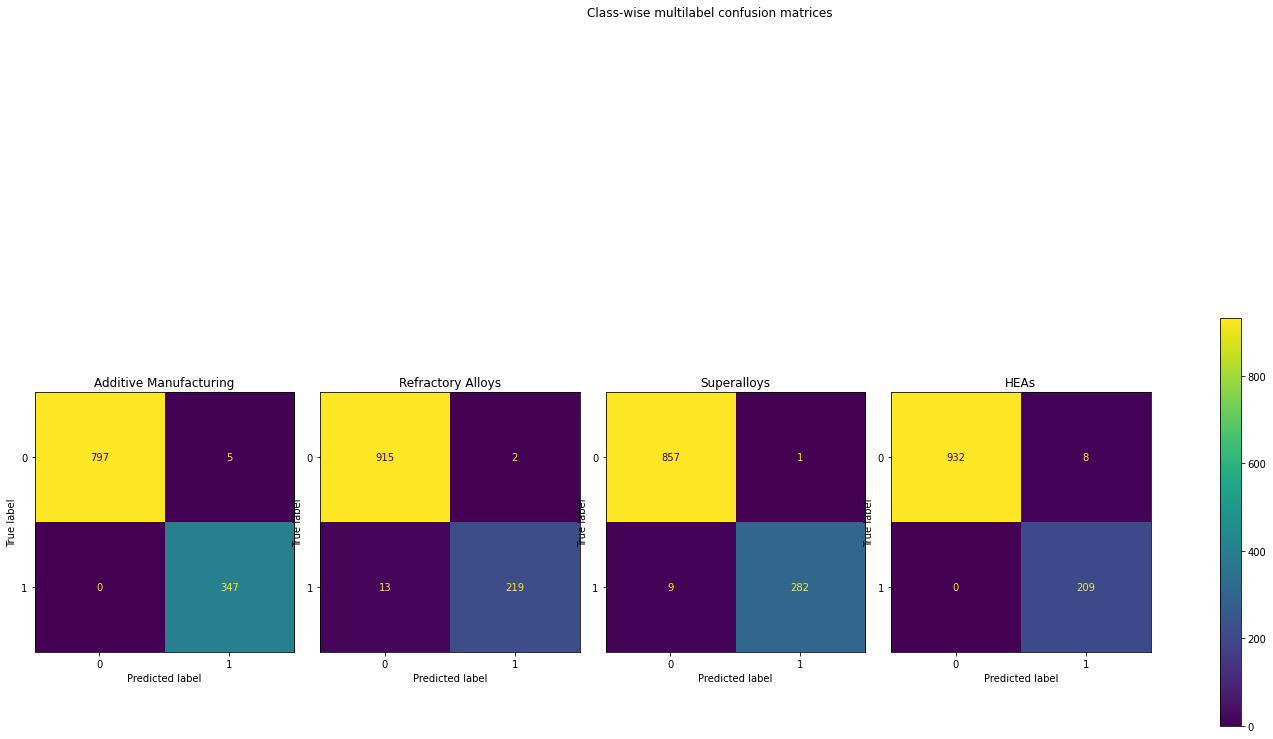

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = multilabel_confusion_matrix(y_test, y_pred_test)

f, axes = plt.subplots(1, len(df['Label'].iloc[0]), figsize=(25, 15))
axes = axes.ravel()

for i in range(len(df['Label'].iloc[0])):
    disp = ConfusionMatrixDisplay(conf_mat[i], display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(class_list[i])
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes, shrink=0.5)
f.suptitle('Class-wise multilabel confusion matrices')
plt.show()

## Relocating Incorrectly Labeled Abstracts

In [ ]:
def abstracts_incorrect(dataset, y_true, y_pred):
    '''
    Find incorrectly predicted abstracts from test data. Saves to csv.

    Args:
        dataset (DatasetDict): Huggingface dataset containing raw abstracts
    
    Returns:
        AI (pandas.DataFrame): Incorrectly classified abstracts
    '''

    # Define tokenize function again in function scope
    def tokenize_function(examples):
        """Applies tokenizer to abstract text"""
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

    # Retrieve incorrectly classified eval abstracts
    incorrect_indices = np.where(np.not_equal(y_true, y_pred))[0]
    abstracts_incorrect = dataset.select(incorrect_indices)

    # Confirm these were misclassified running through same tokenizing and tf steps
    tokenized_abs_inc = abstracts_incorrect.map(tokenize_function, batched=True)
    tf_eval_abs_inc = tokenized_abs_inc.remove_columns(["text"]).with_format("tensorflow")
    eval_features_abs_inc = {x: tf_eval_abs_inc[x] for x in tokenizer.model_input_names}
    eval_tf_abs_inc = tf.data.Dataset.from_tensor_slices((eval_features_abs_inc, tf_eval_abs_inc["label"]))
    eval_tf_abs_inc = eval_tf_abs_inc.batch(8)
    y_probs_inc = model.predict(eval_tf_abs_inc).logits

    print(y_probs_inc)

    # Predict
    pred = lambda x: float(1) if x >= float(0) else float(0)
    vpred = np.vectorize(pred)
    y_pred_inc = vpred(y_probs_inc)

    y_test_inc = np.concatenate([y for x, y in eval_tf_abs_inc], axis=0)

    # Should have zero accuracy as all in set misclassified
    assert(isclose(sklearn.metrics.accuracy_score(y_test_inc, y_pred_inc), 0))
    AI = pd.DataFrame(abstracts_incorrect)
    AI['pred_label'] = list(y_pred_inc)
    AI.to_csv('incorrect.csv')
    return AI

In [ ]:
abs_inc = abstracts_incorrect(dataset['test'], y_test, y_pred_test)

  0%|          | 0/1 [00:00<?, ?ba/s]

5/5 [==============================] - 2s 319ms/step
[[-6.4091225  -4.523502   -6.0410113  -5.757374  ]
 [-6.427864   -4.7941675  -5.882722   -5.6425247 ]
 [-6.0447073   4.2723083  -6.0452156  -5.5972605 ]
 [ 6.154221   -4.781186   -5.7477303  -5.932596  ]
 [ 5.274023   -4.7280593  -5.798966    4.543685  ]
 [-6.5101666  -5.1625323  -5.4747014  -5.6587367 ]
 [-8.749928   -2.814642   -5.978758    2.4961662 ]
 [-8.749928   -2.814642   -5.978758    2.4961662 ]
 [-7.033143   -2.155526   -6.1007977  -6.35386   ]
 [ 5.1535854  -4.906348   -5.404024    4.8562512 ]
 [-8.817764    0.25574502 -6.4138036   1.0564674 ]
 [ 1.4148835  -6.5040846   6.3037424  -6.33907   ]
 [-7.9285655  -0.69236326 -5.9799304  -5.668767  ]
 [ 5.0929923  -5.9569182  -4.6463585  -6.5075226 ]
 [-8.5330105  -1.4570658  -6.362083    2.5534775 ]
 [-8.5330105  -1.4570658  -6.362083    2.5534775 ]
 [ 4.212546    3.6818607  -5.4445415  -6.031175  ]
 [-6.3698616  -5.4284086  -5.7318482   5.064059  ]
 [ 3.5015378   4.0163574  -5.

## Visualizing Training/Test Losses & Accuracies

It is common procedure to produce plots observing the losses and accuracies during fine-tuning.

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_loss(cvs_log):
    '''
    Plots training/test losses and accuracies from training using the cvs_log

    Args:
        cvs_log (string): File path to cvs log from training

    Returns:
        Void
    '''
    cvs_log = np.genfromtxt(cvs_log, delimiter=',')

    epochs = cvs_log[:, 0]
    train_loss = cvs_log[:, 2]
    train_acc = cvs_log[:, 1]
    test_loss = cvs_log[:, 4]
    test_acc = cvs_log[:, 3]

    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    # Losses
    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, train_loss, 'x-r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, test_loss, 'o-b', label='Test loss')
    plt.title('Training and Test Loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracies
    plt.subplot(2, 1, 2)
    plt.plot(epochs, train_acc, 'x-r', label='Training acc')
    plt.plot(epochs, test_acc, 'o-b', label='Test acc')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Adjust layout
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    
    plt.show()

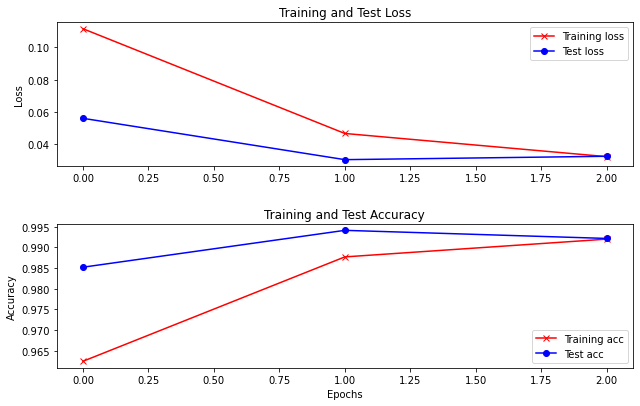

In [ ]:
plot_acc_loss('/content/cvs_log.csv')

# Push to Hub

In [ ]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 2s (971 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155455 files and directories cur

In [ ]:
from huggingface_hub import notebook_login

notebook_login()
tokenizer.push_to_hub("ndavid/MatBERT-multi-label")
model.push_to_hub("ndavid/MatBERT-multi-label")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='MatBERT-multi-label' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/ndavid/MatBERT-multi-label into local empty directory.
To https://huggingface.co/ndavid/MatBERT-multi-label
   3632b8a..ed8101c  main -> main



Upload file tf_model.h5:   0%|          | 3.34k/418M [00:00<?, ?B/s]

To https://huggingface.co/ndavid/MatBERT-multi-label
   ed8101c..9a674d5  main -> main



'https://huggingface.co/ndavid/MatBERT-multi-label/commit/9a674d531a2716d3dc795d4e1d43793fc5bceebd'